# Lunar Lander using Images

### Sitabja Ukil (17200734) & Anandita Pal (17200262)

Train a supervised machine learning model to control the Lunar Lander
craft based on the image dataset.

<h2>Imports</h2>

In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils
import time

Using TensorFlow backend.


<h2>Preparing the data</h2>

Load the raw image dataset and pre-process it. Divide this into train and test splits. Balance the training split.

<h3> Load the images </h3>

Load a set of images and resize each image to 84x84 and covert each to black and white. 

In [2]:
# Set up some parmaeters for data loading
TRAIN_DIR = 'data/'
sample_rate = 0.5
ROWS = 84
COLS = 84
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] 
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate through the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
    image = image.reshape(1, 1, image.shape[0], image.shape[1])
    data[i] = image
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

Processed 0 of 32161
Processed 1000 of 32161
Processed 2000 of 32161
Processed 3000 of 32161
Processed 4000 of 32161
Processed 5000 of 32161
Processed 6000 of 32161
Processed 7000 of 32161
Processed 8000 of 32161
Processed 9000 of 32161
Processed 10000 of 32161
Processed 11000 of 32161
Processed 12000 of 32161
Processed 13000 of 32161
Processed 14000 of 32161
Processed 15000 of 32161
Processed 16000 of 32161
Processed 17000 of 32161
Processed 18000 of 32161
Processed 19000 of 32161
Processed 20000 of 32161
Processed 21000 of 32161
Processed 22000 of 32161
Processed 23000 of 32161
Processed 24000 of 32161
Processed 25000 of 32161
Processed 26000 of 32161
Processed 27000 of 32161
Processed 28000 of 32161
Processed 29000 of 32161
Processed 30000 of 32161
Processed 31000 of 32161
Processed 32000 of 32161
Train shape: (32161, 1, 84, 84)


<h3> Generating the labels </h3>

The possible target labels here are - (0) no action, (1) left, (2) up, and (3) right. The lables can be created by looping over the file names in the train directory.

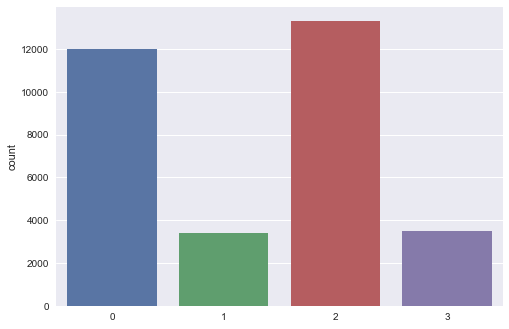

In [3]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
sns.countplot(labels)

<h3>Show some screens</h3>

Print a few screens with their labels.

2


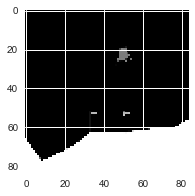

2


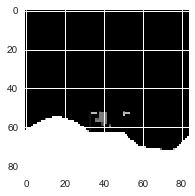

0


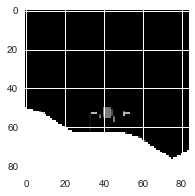

0


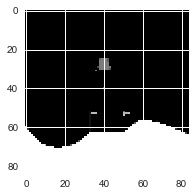

2


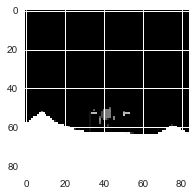

In [4]:
for i in range(0,5):
    idx = random.randint(0, len(labels))
    print(labels[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(data[idx][0], cmap='gray')
    plt.show()

<h3> Partition the dataset for evaluation</h3>

Split the data into a training and test sets so we can evaluate at the end. 

In [5]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

In [6]:
train_labels_wide

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.]])

Apply under sampling to balance the training dataset

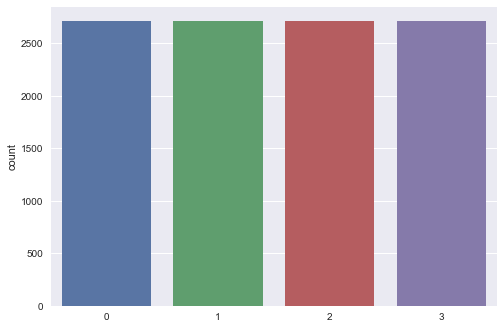

In [7]:
# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
train_rus, train_labels_rus, idx_resampled = rus.fit_sample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), CHANNELS,ROWS, COLS)
sns.countplot(train_labels_rus)
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

We are defining two dictionaries to store the accuracies and training times of the models that we will use.

In [8]:
model_accuracy_comparison = {}
model_training_time_comparison = {}

## Fit the model

We are fitting two CNN models, each with different configuration. We will save the one which performs best.

In [ ]:
INPUT_SHAPE = (ROWS, COLS)
WINDOW_LENGTH = 1
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE

## CNN - Model 1

### Create model

In [27]:
model1 = Sequential()

model1.add(Conv2D(32, (8, 8), padding='same', subsample=(4, 4), input_shape=input_shape, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), dim_ordering = 'th'))
model1.add(Conv2D(64, (4, 4), padding='same', subsample=(2, 2), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), dim_ordering = 'th'))
model1.add(Conv2D(64, (3, 3), padding='same', subsample=(1, 1), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), dim_ordering = 'th'))
model1.add(Flatten())

model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes, activation = 'softmax'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 21, 32)         172064    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 10, 16)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 5, 64)          16448     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 2, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
__________

C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), padding="same", input_shape=(1, 84, 84..., activation="relu", strides=(4, 4))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  after removing the cwd from sys.path.
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu", strides=(2, 2))`
  """
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: User

In [28]:
model1.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

<h3> Train the model </h3>

In [11]:
epochs = 50
batch_size = 128

In [29]:
start_time = time.time()
history1 = model1.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)
model_training_time_comparison['CNN Model 1'] = time.time() - start_time

Train on 8136 samples, validate on 2712 samples
Epoch 1/50
8136/8136 [==============================] - 10s 1ms/step - loss: 1.3868 - acc: 0.2477 - val_loss: 1.3837 - val_acc: 0.3289
Epoch 2/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.3077 - acc: 0.3450 - val_loss: 1.2384 - val_acc: 0.3698
Epoch 3/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.2390 - acc: 0.3686 - val_loss: 1.2208 - val_acc: 0.3573
Epoch 4/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.2167 - acc: 0.3767 - val_loss: 1.2083 - val_acc: 0.3960
Epoch 5/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.1842 - acc: 0.4251 - val_loss: 1.1488 - val_acc: 0.4355
Epoch 6/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.0650 - acc: 0.4953 - val_loss: 1.0246 - val_acc: 0.5033
Epoch 7/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.0002 - acc: 0.5199 - val_loss: 1.0173 - val_acc: 0.5041
Epoch 8/50
81

Plot the evolution of the loss as the module was trained.

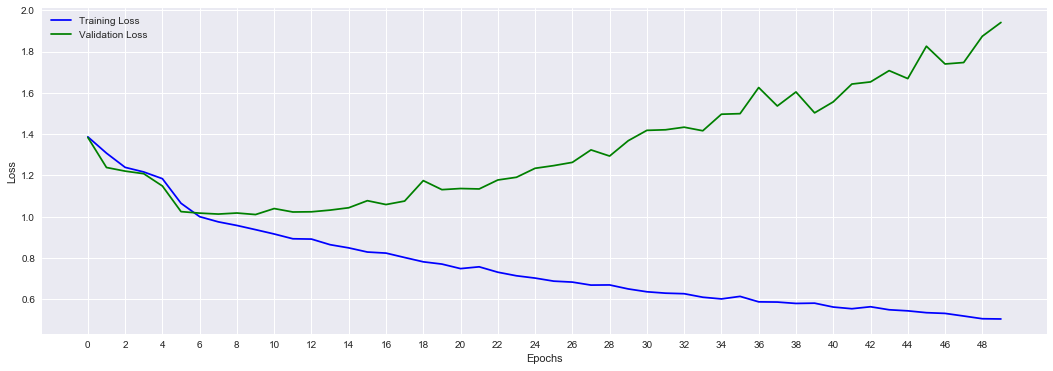

In [30]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.figure(figsize=(18,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

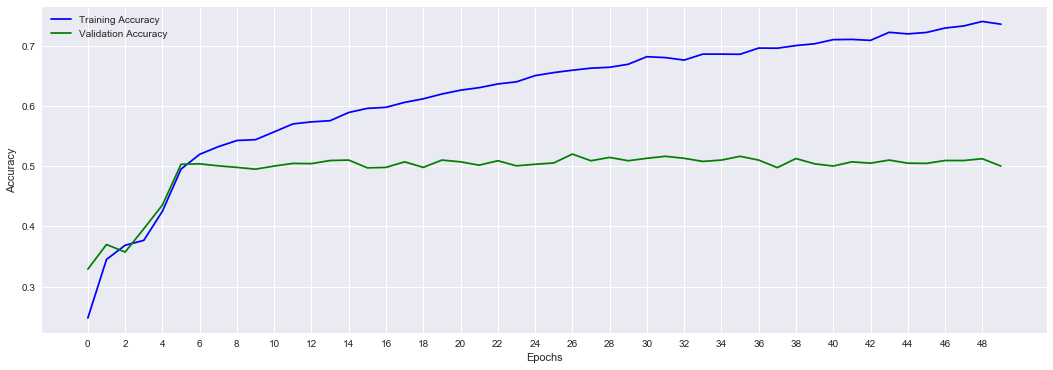

In [47]:
accuracy = history1.history['acc']
val_accuracy= history1.history['val_acc']
plt.figure(figsize=(18,6))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy, 'blue', label='Training Accuracy')
plt.plot(val_accuracy, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

<h3> Evaluate the model </h3>

Use the test dataset to evaluate the model

In [31]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = model1.predict_classes(test)

# Print performance details
accuracy = metrics.accuracy_score(test_labels, pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_labels, pred))
model_accuracy_comparison['CNN Model 1'] = accuracy
# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))

****** Test Data ********
Accuracy: 0.399658013369
             precision    recall  f1-score   support

          0       0.44      0.38      0.41      2395
          1       0.33      0.68      0.45       681
          2       0.48      0.27      0.35      2659
          3       0.33      0.67      0.44       698

avg / total       0.43      0.40      0.39      6433

Confusion Matrix
[[915 439 598 443]
 [ 85 466  95  35]
 [976 470 720 493]
 [101  34  93 470]]


## CNN - Model 2

### Create model

In [32]:
model2 = Sequential()

model2.add(Conv2D(32, (8, 8), padding='same', subsample=(4, 4), input_shape=input_shape, activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2, 2), dim_ordering = 'th'))
model2.add(Conv2D(64, (4, 4), padding='same', subsample=(2, 2), activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2, 2), dim_ordering = 'th'))
model2.add(Conv2D(64, (3, 3), padding='same', subsample=(1, 1), activation='relu'))
model2.add(Dropout(0.5))
model2.add(MaxPooling2D(pool_size=(2, 2), dim_ordering = 'th'))
model2.add(Flatten())

model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(num_classes, activation = 'softmax'))

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 21, 32)         172064    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 21, 32)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 10, 16)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 5, 64)          16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 5, 64)          0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 2, 64)          18496     
__________

C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), padding="same", input_shape=(1, 84, 84..., activation="relu", strides=(4, 4))`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  """
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu", strides=(2, 2))`
  
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  
C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to

In [33]:
model2.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-3), metrics=['accuracy'])

### Train the model 

In [34]:
epochs = 50
batch_size = 128

In [35]:
start_time = time.time()
history = model2.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)
model_training_time_comparison['CNN Model 2'] = time.time() - start_time

Train on 8136 samples, validate on 2712 samples
Epoch 1/50
8136/8136 [==============================] - 10s 1ms/step - loss: 1.3877 - acc: 0.2480 - val_loss: 1.3860 - val_acc: 0.2426
Epoch 2/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.3608 - acc: 0.3052 - val_loss: 1.3011 - val_acc: 0.3341
Epoch 3/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.2698 - acc: 0.3711 - val_loss: 1.2683 - val_acc: 0.3732
Epoch 4/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.2403 - acc: 0.3884 - val_loss: 1.2409 - val_acc: 0.3923
Epoch 5/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.1811 - acc: 0.4431 - val_loss: 1.1857 - val_acc: 0.4764
Epoch 6/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.1144 - acc: 0.4846 - val_loss: 1.1304 - val_acc: 0.4856
Epoch 7/50
8136/8136 [==============================] - 9s 1ms/step - loss: 1.0832 - acc: 0.4876 - val_loss: 1.1100 - val_acc: 0.4867
Epoch 8/50
81

Plot the evolution of the loss as the module was trained.

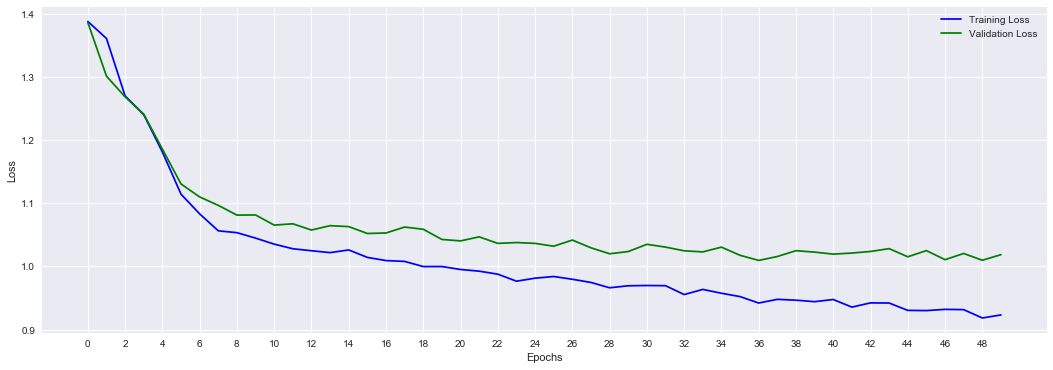

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(18,6))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

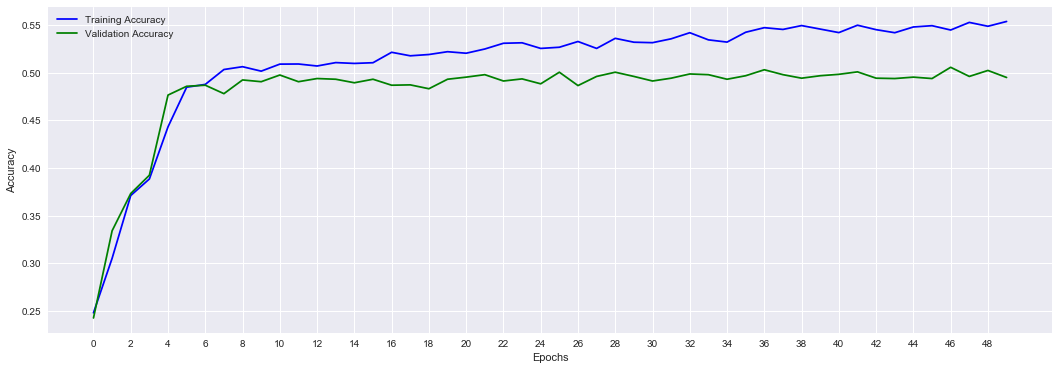

In [46]:
accuracy = history.history['acc']
val_accuracy= history.history['val_acc']
plt.figure(figsize=(18,6))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(accuracy, 'blue', label='Training Accuracy')
plt.plot(val_accuracy, 'green', label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluate the model 

Use the test dataset to evaluate the model

In [37]:
print("****** Test Data ********")
# Make a set of predictions for the validation data
pred = model2.predict_classes(test)

# Print performance details
accuracy = metrics.accuracy_score(test_labels, pred) 
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(test_labels, pred))
model_accuracy_comparison['CNN Model 2'] = accuracy
# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(test_labels, pred))

****** Test Data ********
Accuracy: 0.465723612622
             precision    recall  f1-score   support

          0       0.43      0.79      0.55      2395
          1       0.62      0.54      0.57       681
          2       0.45      0.14      0.21      2659
          3       0.62      0.53      0.57       698

avg / total       0.48      0.47      0.42      6433

Confusion Matrix
[[1886   89  324   96]
 [ 234  367   76    4]
 [2037  120  370  132]
 [ 258   20   47  373]]


## Compare the accuracies of the two trained models

Compare the performance of the two CNN models.

In [39]:
model_accuracy_comparison

{'CNN Model 1': 0.39965801336856832, 'CNN Model 2': 0.46572361262241568}

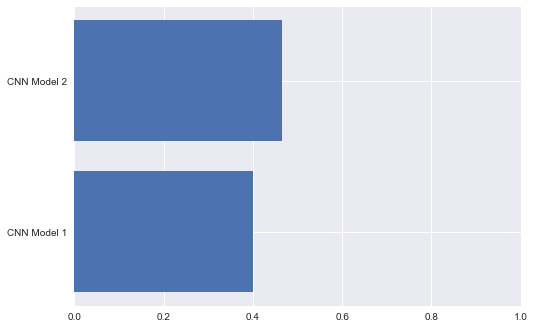

In [40]:
#Plot the accuracy
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_accuracy_comparison)), list(model_accuracy_comparison.values()), align='center')
_= plt.yticks(range(len(model_accuracy_comparison)), list(model_accuracy_comparison.keys()))
plt.show()

The above plot shows that the second model has the highest accuracy.

## Compare the training times of the two trained models

Compare the time taken to train each of the two CNN models.

In [38]:
model_training_time_comparison

{'CNN Model 1': 453.29762387275696, 'CNN Model 2': 455.1955666542053}

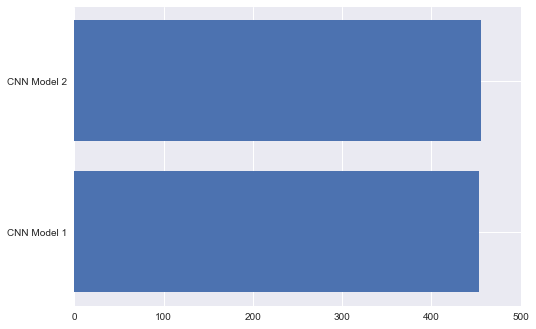

In [41]:
#Plot the accuracy
plt.xlim(0, 500.0)
_ = plt.barh(range(len(model_training_time_comparison)), list(model_training_time_comparison.values()), align='center')
_= plt.yticks(range(len(model_training_time_comparison)), list(model_training_time_comparison.keys()))
plt.show()

The above plot shows that the two models has taken almost the same time to train.

## Save best model

From the above results it is clear that the performance of the second model is the best among the two. Hence we are saving the second model as our image based model.

In [42]:
# save model
filepath = "player_CNN.mod"
model2.save(filepath)